In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

# Import and inspect data

## Import

In [ ]:
def import_data():
    """Import training and testing data, as data and labels"""
    
    # Import in pandas (np.genfromtxt is too slow)
    tr_pd = pd.read_csv('data_train.csv', header=None)
    tst_pd = pd.read_csv('data_test.csv', header=None)
    
    # Split data and labels
    tr_data = np.array(tr_pd.loc[:, 1:])
    tr_labels = np.array(tr_pd.loc[:, 0])
    tst_data = np.array(tst_pd.loc[:, 1:])
    tst_labels = np.array(tst_pd.loc[:, 0])
    
    return tr_data, tst_data, tr_labels, tst_labels

In [ ]:
g_tr_data, g_tst_data, g_tr_labels, g_tst_labels = import_data()
g_tr_data = g_tr_data/255
g_tst_data = g_tst_data/255

## Inspect

In [ ]:
def inspect_number(data, img_nums, savefig=False):
    """Display image. img_nums should be entered as list."""
    
    num_images = len(img_nums)
    # Reshape datasets into pixel array
    data_rs = np.reshape(data, newshape=(data.shape[0], 28, 28))
    
    figsize = (10, 1)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for k in range(num_images):
        ax = axes[k]
        ax.imshow(data_rs[img_nums[k]], cmap='Greys')
        ax.set_axis_off()
    if savefig is not False:
        plt.savefig(savefig + '.pdf')
    plt.show()

In [ ]:
inspect_number(g_tr_data, np.arange(10), savefig=False)

# Build VAE in Tensorflow

In [ ]:
class AutoEncoder():
    """Autoencoder. For most examples, self.inp=self.tgt, but these are considered 
    independent variables to make extensions more straightforward."""
    
    def __init__(self, num_z, learn_param):
        self.batch_size = 100
        self.num_z = num_z    # Number of dimensions of latent space
        self.learn_param = learn_param
        
        self.inp = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='inputs')
        self.tgt = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='targets')
        self.feedfwd_z = tf.placeholder(dtype=tf.float32, shape=[None, num_z], name='feedfwd_z')
        self.sess = tf.Session()
        self._build_graph()
        self.sess.run(tf.initializers.global_variables())
    
    def _build_graph(self):
        """Build neural network"""
        initializer = tf.glorot_uniform_initializer()
        
        # Encoder: convolutional neural network
        enc_h = tf.reshape(self.inp, shape=[-1, 28, 28, 1])    
        enc_h = tf.layers.conv2d(enc_h, 16, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='enc_conv1')    # 28x28 -> 14x14x16
        print(enc_h)
        enc_h = tf.layers.conv2d(enc_h, 32, kernel_size=[5, 5], strides=[2, 2], padding='same',
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='enc_conv2')    # 14x14x16 -> 7x7x32
        print(enc_h)
        enc_h = tf.reshape(enc_h, [-1, 7*7*32])

        # Bottleneck with reparametrisation trick
        self.mu = tf.layers.dense(enc_h, self.num_z, kernel_initializer=initializer,
                                  activation=None, name='mu')
        print(self.mu)
        self.log_sigma = tf.layers.dense(enc_h, self.num_z, kernel_initializer=initializer,
                                         activation=None, name='log_sigma')
        print(self.log_sigma)
        self.z = tf.add(self.mu, 
                        tf.multiply(tf.exp(0.5 * self.log_sigma), 
                                    tf.random.normal(shape=[tf.shape(self.mu)[0], 
                                                            self.num_z]),
                        name='z'))
        print(self.z)

        # Decoder: deconvolutional neural network
        dec_h = tf.layers.dense(self.z, 7*7*32, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='dec_dense1')
        print(dec_h)
        dec_h = tf.reshape(dec_h, [-1, 7, 7, 32])
        print(dec_h)
        dec_h = tf.layers.conv2d_transpose(dec_h, 16, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='dec_deconv1')    # 7x7x32 -> 14x14x16
        print(dec_h)
        dec_h = tf.layers.conv2d_transpose(dec_h, 1, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.sigmoid, 
                             name='dec_deconv2')    # 14x14x16 -> 28x28x1
        print(dec_h)
        self.out = tf.reshape(dec_h, [-1, 784])
    
        # Optimizer: sum of generation loss and KL divergence
        self.loss_gen = -tf.reduce_sum(self.tgt * tf.log(1e-10 + self.out) + \
                                       (1 - self.tgt) * tf.log(1e-10 + 1 - self.out), 
                           axis=1)
        self.loss_KL = \
            0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(tf.exp(self.log_sigma)) - \
                                tf.log(tf.square(tf.exp(self.log_sigma))) - 1, axis=1)
        self.cost = tf.reduce_mean(tf.add(self.loss_gen, self.loss_KL))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learn_param).minimize(self.cost)
        
        # Second decoder to feedforward z values
        dec_h2 = tf.layers.dense(self.feedfwd_z, 7*7*32, kernel_initializer=initializer, 
                            activation=tf.nn.relu, name='dec_dense1', reuse=True)
        print(dec_h2)
        dec_h2 = tf.reshape(dec_h2, [-1, 7, 7, 32])
        print(dec_h2)
        dec_h2 = tf.layers.conv2d_transpose(dec_h2, 16, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.relu, 
                             name='dec_deconv1', reuse=True)    # 7x7x32 -> 14x14x16
        print(dec_h2)
        dec_h2 = tf.layers.conv2d_transpose(dec_h2, 1, kernel_size=[5, 5], strides=[2, 2], padding='same', 
                             kernel_initializer=initializer, activation=tf.nn.sigmoid, 
                             name='dec_deconv2', reuse=True)    # 14x14x16 -> 28x28x1
        print(dec_h2)
        self.feedfwd_out = tf.reshape(dec_h2, [-1, 784])
        
    def evaluate_AE_outputs(self, data_inp, data_tgt):
        """Run the variational autoencoder on some data and evaluate the mean squared error"""
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        z, outputs, cost = self.sess.run([self.z, self.out, self.cost], feed_dict=feed_dict)
        return z, outputs, cost
        
    def evaluate_z_outputs(self, z):
        """Run the decoder given some z values"""
        feed_dict = {self.feedfwd_z: z}
        outputs = self.sess.run(self.feedfwd_out, feed_dict=feed_dict)
        return outputs
        
    def make_minibatch(self, data_inp, data_tgt, batch_num):
        """Form a minibatch from the data"""
        llim = batch_num * self.batch_size
        rlim = (batch_num + 1) * self.batch_size
        return data_inp[llim:rlim], data_tgt[llim:rlim]
    
    def estimate_plots(self, data_inp, img_nums, savefig=False):
        """Plot the autoencoder estimates over some images"""
        self.run_size = data_inp.shape[0]
        estimates = self.evaluate_AE_outputs(data_inp[img_nums], data_inp[img_nums])[1]
        # print(np.round(estimates[0, :10], 20))   # For debugging
        inspect_number(estimates, img_nums, savefig=savefig)
        
    def plot_z(self, data_z, data_labels, savefig=False):
        """Plot z values in 2-space (if z-space is 2-dimensional)"""
        fig, ax = plt.subplots()
        for label in range(10):
            data = data_z[data_labels == label]
            ax.scatter(data[:, 0], data[:, 1])
        ax.set_xlabel('z1')
        ax.set_ylabel('z2')
        plt.axis('equal')
        if savefig:
            plt.savefig('z_output_pic.pdf')
        plt.show()
    
    def train_iteration(self, data_inp, data_tgt):
        """Do one training iteration over the input data"""
        self.run_size = data_inp.shape[0]
        feed_dict = {self.inp: data_inp, self.tgt: data_tgt}
        _, out = self.sess.run([self.optimizer, self.out], feed_dict=feed_dict)
        
    def train_full(self, tr_inp, tr_tgt, tst_inp, tst_tgt, num_epochs, 
                   info=True, infoplots=False):
        """Train neural network and keep track of progress by (cross) validating"""
        
        # batch_size must divide num_tr_points
        num_tr_pts = tr_inp.shape[0]
        num_tst_pts = tst_inp.shape[0]
        num_batches = int(round(num_tr_pts / self.batch_size)) 
        
        # Train the MLP and keep track of the errors across training and testing datasets
        batch_nums, epochs, tr_costs, tst_costs = \
                np.array([]), np.array([]), np.array([]), np.array([])
        for epoch in range(num_epochs):
            for batch_num in range(num_batches):
                # Input proportion correctly identified across training, testing dataset
                if batch_num % 50 == 0:
                    tr_z, tr_out, tr_cost = self.evaluate_AE_outputs(tr_inp, tr_tgt)
                    tst_z, tst_out, tst_cost = self.evaluate_AE_outputs(tst_inp, tst_tgt)
#                    self.plot_z(tr_z, g_tr_labels)
                    if info is True:
                        print('Cost after {} batches: Tr {}, Tst {}'.format(
                            batch_num, tr_cost, tst_cost))
                    if infoplots is True: 
                        self.estimate_plots(g_tr_data, np.arange(10), 
                                            savefig=str(epoch) + '_' + str(batch_num) +'.pdf')
                    epochs = np.append(epochs, epoch)
                    batch_nums = np.append(batch_nums, batch_num)
                    tr_costs = np.append(tr_costs, tr_cost)
                    tst_costs = np.append(tst_costs, tst_cost)
                
                # Do the training over a minibatch
                mb_tr_inp, mb_tr_tgt = \
                    self.make_minibatch(tr_inp, tr_tgt, batch_num=batch_num) 
                self.train_iteration(mb_tr_inp, mb_tr_tgt)    # Single training iteration
                
        if infoplots is True:
            self.estimate_plots(g_tr_data, np.arange(10), savefig=False)
#            self.plot_z(tr_z, g_tr_labels, savefig=False)
                
        costs = pd.DataFrame(np.vstack((epochs, batch_nums, tr_costs, tst_costs)).T, 
                             columns = ['epoch', 'batch', 'train', 'test'])
        return costs

In [64]:
tf.reset_default_graph()
model = AutoEncoder(num_z=10, learn_param=0.01)

Tensor("enc_conv1/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("enc_conv2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("mu/BiasAdd:0", shape=(?, 10), dtype=float32)
Tensor("log_sigma/BiasAdd:0", shape=(?, 10), dtype=float32)
Tensor("Add:0", shape=(?, 10), dtype=float32)
Tensor("dec_dense1/Relu:0", shape=(?, 1568), dtype=float32)
Tensor("Reshape_2:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("dec_deconv1/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("dec_deconv2/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("dec_dense1_1/Relu:0", shape=(?, 1568), dtype=float32)
Tensor("Reshape_4:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("dec_deconv1_1/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("dec_deconv2_1/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)


Cost after 0 batches: Tr 543.7079467773438, Tst 543.7074584960938


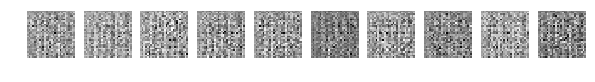

Cost after 50 batches: Tr 326.2727355957031, Tst 327.2379150390625


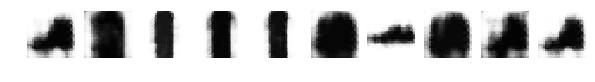

Cost after 100 batches: Tr 295.66845703125, Tst 296.82830810546875


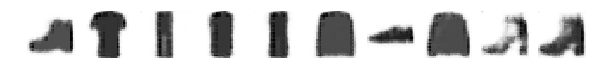

Cost after 150 batches: Tr 277.82440185546875, Tst 279.28485107421875


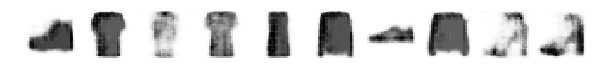

Cost after 200 batches: Tr 271.35528564453125, Tst 273.01995849609375


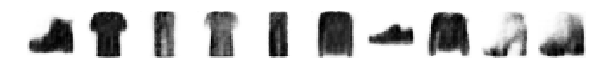

Cost after 250 batches: Tr 265.0302734375, Tst 266.65106201171875


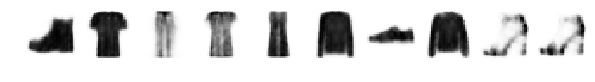

Cost after 300 batches: Tr 262.7943115234375, Tst 264.5037536621094


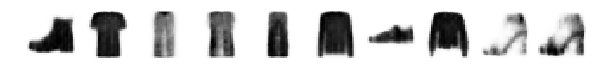

Cost after 350 batches: Tr 261.3100891113281, Tst 263.0533752441406


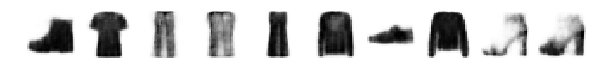

Cost after 400 batches: Tr 262.056640625, Tst 263.7984619140625


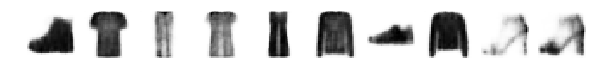

Cost after 450 batches: Tr 259.9056701660156, Tst 261.4921569824219


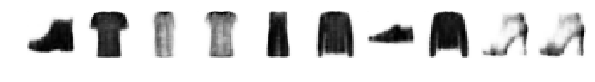

Cost after 500 batches: Tr 259.462158203125, Tst 261.0983581542969


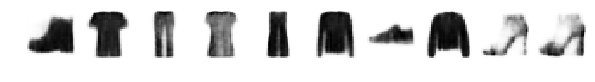

Cost after 550 batches: Tr 259.8627014160156, Tst 261.6168212890625


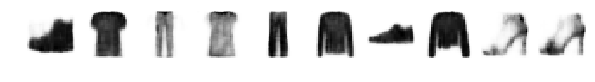

Cost after 0 batches: Tr 258.9126281738281, Tst 260.6265869140625


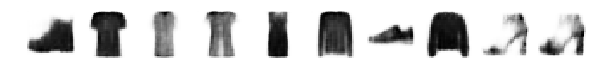

Cost after 50 batches: Tr 258.8273620605469, Tst 260.5622863769531


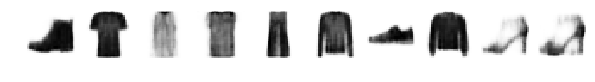

Cost after 100 batches: Tr 258.5094299316406, Tst 260.1844177246094


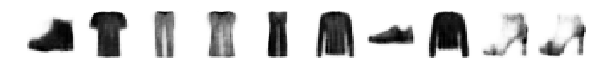

Cost after 150 batches: Tr 257.8257141113281, Tst 259.54302978515625


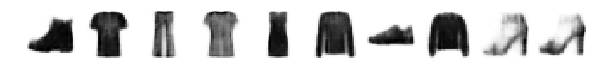

Cost after 200 batches: Tr 257.3299865722656, Tst 258.89862060546875


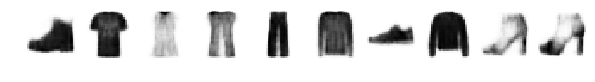

Cost after 250 batches: Tr 256.82684326171875, Tst 258.4143981933594


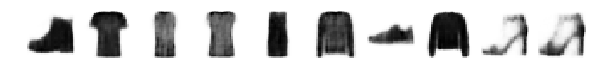

Cost after 300 batches: Tr 257.5964050292969, Tst 259.27203369140625


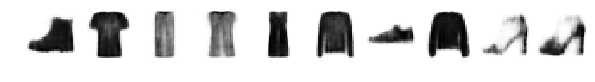

Cost after 350 batches: Tr 257.3597412109375, Tst 259.0637512207031


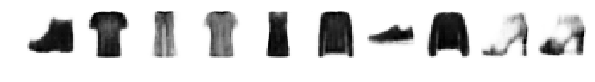

Cost after 400 batches: Tr 256.6075134277344, Tst 258.32757568359375


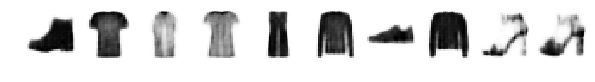

Cost after 450 batches: Tr 257.242919921875, Tst 258.9742126464844


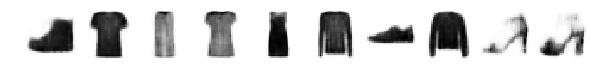

Cost after 500 batches: Tr 256.59271240234375, Tst 258.3785705566406


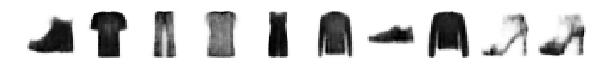

Cost after 550 batches: Tr 256.5995788574219, Tst 258.1092529296875


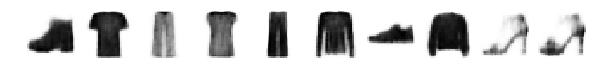

Cost after 0 batches: Tr 256.4089050292969, Tst 258.121337890625


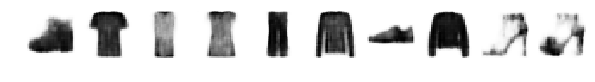

Cost after 50 batches: Tr 256.5768127441406, Tst 258.20880126953125


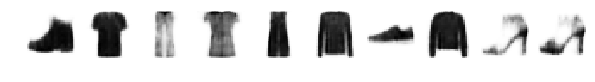

Cost after 100 batches: Tr 256.04815673828125, Tst 257.7602844238281


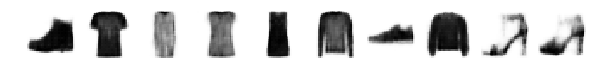

Cost after 150 batches: Tr 255.72970581054688, Tst 257.3924560546875


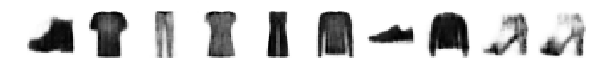

Cost after 200 batches: Tr 255.80715942382812, Tst 257.4423522949219


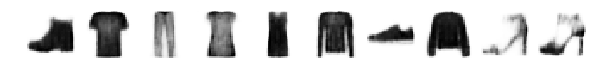

Cost after 250 batches: Tr 256.22430419921875, Tst 257.96575927734375


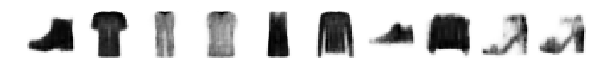

Cost after 300 batches: Tr 256.8374328613281, Tst 258.6336364746094


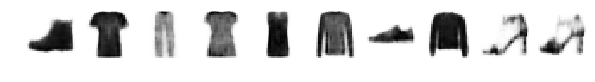

Cost after 350 batches: Tr 255.6737518310547, Tst 257.2019348144531


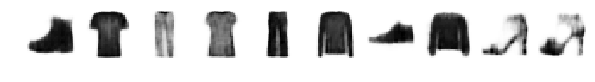

Cost after 400 batches: Tr 255.76153564453125, Tst 257.5508117675781


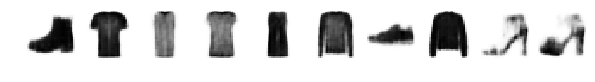

Cost after 450 batches: Tr 254.9917449951172, Tst 256.7405090332031


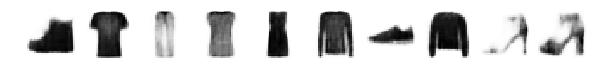

Cost after 500 batches: Tr 256.24713134765625, Tst 258.02410888671875


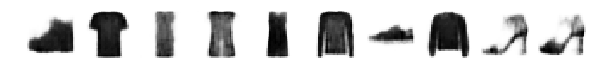

Cost after 550 batches: Tr 255.10877990722656, Tst 256.7518005371094


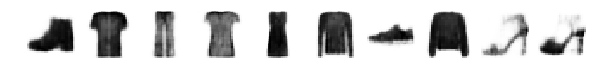

Cost after 0 batches: Tr 255.05714416503906, Tst 256.6657409667969


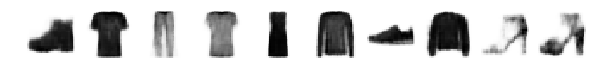

Cost after 50 batches: Tr 255.716796875, Tst 257.4616394042969


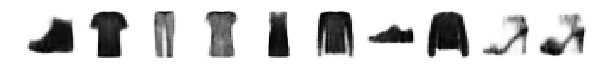

Cost after 100 batches: Tr 254.959228515625, Tst 256.6857604980469


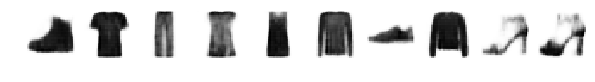

Cost after 150 batches: Tr 255.22634887695312, Tst 256.8961181640625


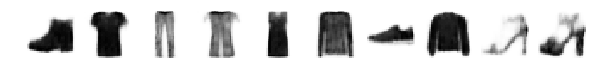

Cost after 200 batches: Tr 254.6971435546875, Tst 256.4529113769531


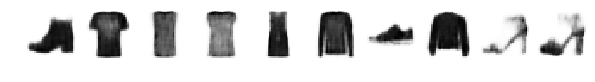

Cost after 250 batches: Tr 254.6762237548828, Tst 256.549560546875


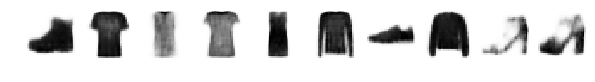

Cost after 300 batches: Tr 255.53701782226562, Tst 257.1789855957031


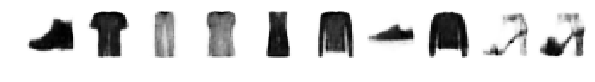

Cost after 350 batches: Tr 258.0155334472656, Tst 259.810302734375


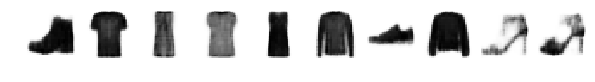

Cost after 400 batches: Tr 255.1942596435547, Tst 256.8670349121094


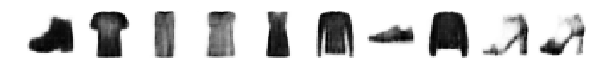

Cost after 450 batches: Tr 254.3209686279297, Tst 256.1101379394531


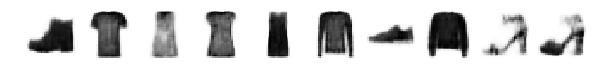

Cost after 500 batches: Tr 254.60403442382812, Tst 256.4132385253906


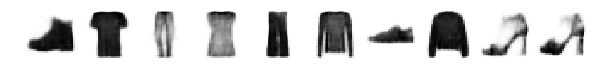

Cost after 550 batches: Tr 254.63369750976562, Tst 256.35430908203125


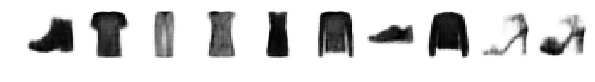

Cost after 0 batches: Tr 255.29502868652344, Tst 257.0697326660156


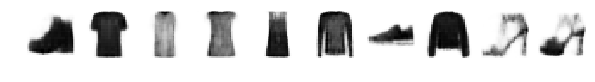

Cost after 50 batches: Tr 254.13763427734375, Tst 256.01708984375


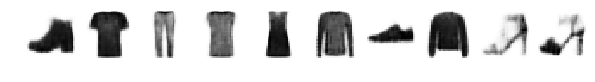

Cost after 100 batches: Tr 254.73406982421875, Tst 256.39434814453125


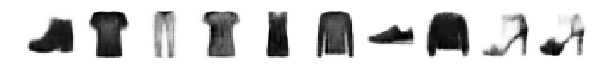

Cost after 150 batches: Tr 254.39431762695312, Tst 256.0133972167969


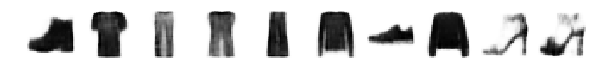

Cost after 200 batches: Tr 254.44720458984375, Tst 256.307861328125


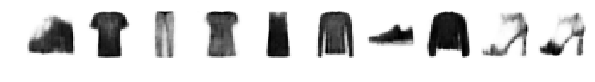

Cost after 250 batches: Tr 254.30760192871094, Tst 256.1357421875


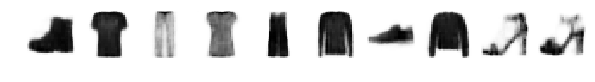

Cost after 300 batches: Tr 254.139892578125, Tst 255.858642578125


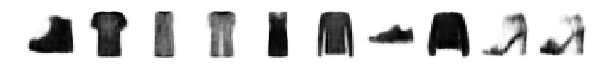

Cost after 350 batches: Tr 254.42202758789062, Tst 256.2108459472656


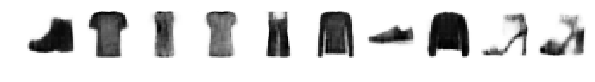

Cost after 400 batches: Tr 255.17962646484375, Tst 256.877197265625


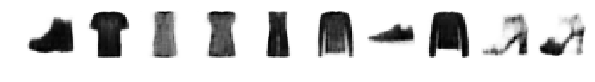

Cost after 450 batches: Tr 253.7353973388672, Tst 255.52940368652344


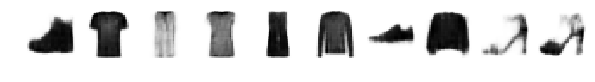

Cost after 500 batches: Tr 254.06617736816406, Tst 255.94039916992188


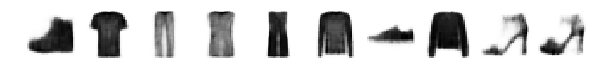

Cost after 550 batches: Tr 254.0359649658203, Tst 255.85452270507812


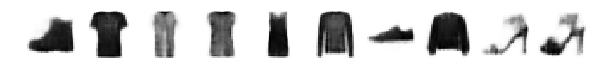

Cost after 0 batches: Tr 254.33531188964844, Tst 256.1584167480469


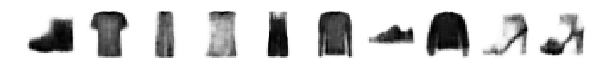

Cost after 50 batches: Tr 255.57164001464844, Tst 257.45281982421875


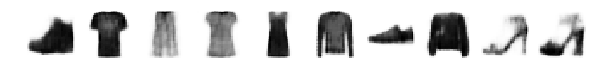

Cost after 100 batches: Tr 254.16488647460938, Tst 256.0457458496094


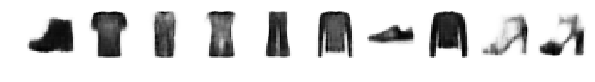

Cost after 150 batches: Tr 254.98558044433594, Tst 256.8010559082031


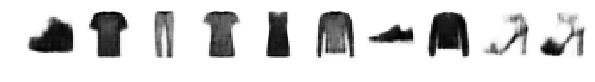

Cost after 200 batches: Tr 254.3671875, Tst 255.9980926513672


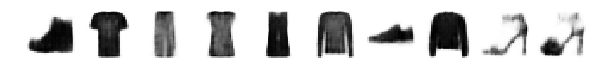

Cost after 250 batches: Tr 254.78587341308594, Tst 256.7108154296875


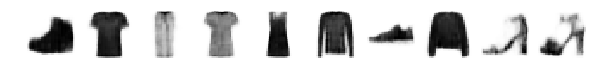

Cost after 300 batches: Tr 254.5213623046875, Tst 256.2401428222656


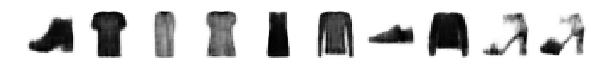

Cost after 350 batches: Tr 254.5370635986328, Tst 256.3633117675781


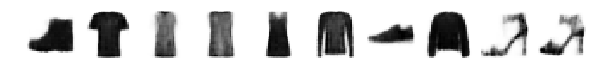

Cost after 400 batches: Tr 254.33026123046875, Tst 256.16156005859375


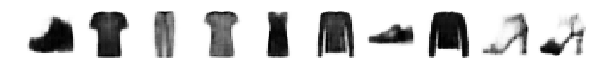

Cost after 450 batches: Tr 254.1742706298828, Tst 255.9673309326172


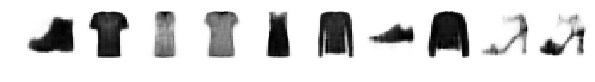

Cost after 500 batches: Tr 253.57814025878906, Tst 255.36669921875


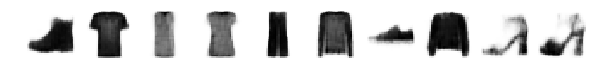

Cost after 550 batches: Tr 254.76220703125, Tst 256.4504089355469


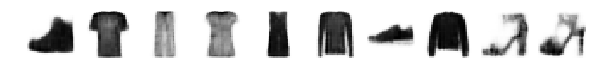

Cost after 0 batches: Tr 253.5114288330078, Tst 255.45867919921875


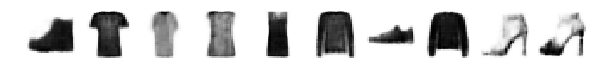

Cost after 50 batches: Tr 253.5874786376953, Tst 255.33509826660156


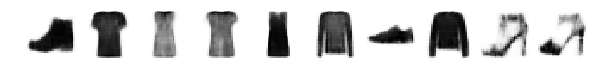

Cost after 100 batches: Tr 253.68112182617188, Tst 255.4897003173828


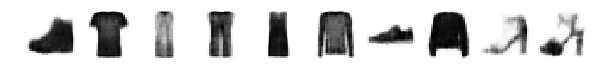

Cost after 150 batches: Tr 254.42202758789062, Tst 256.14202880859375


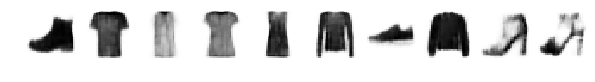

Cost after 200 batches: Tr 254.50347900390625, Tst 256.3236389160156


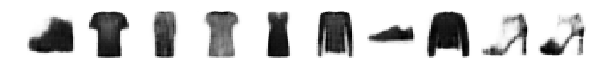

Cost after 250 batches: Tr 253.84046936035156, Tst 255.55047607421875


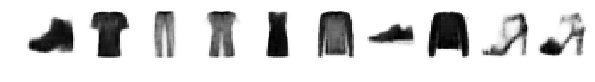

Cost after 300 batches: Tr 253.70359802246094, Tst 255.44064331054688


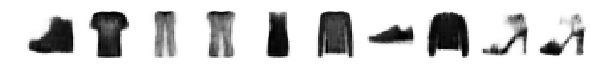

Cost after 350 batches: Tr 254.12832641601562, Tst 255.92974853515625


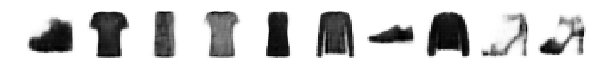

Cost after 400 batches: Tr 253.4243621826172, Tst 255.38311767578125


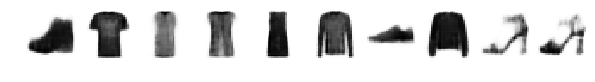

Cost after 450 batches: Tr 255.78280639648438, Tst 257.6588134765625


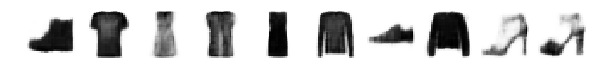

Cost after 500 batches: Tr 253.8645782470703, Tst 255.61842346191406


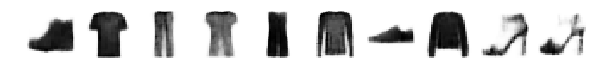

Cost after 550 batches: Tr 253.4786376953125, Tst 255.28570556640625


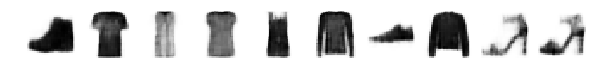

Cost after 0 batches: Tr 253.37855529785156, Tst 255.34735107421875


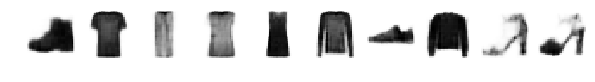

Cost after 50 batches: Tr 253.9484100341797, Tst 255.74220275878906


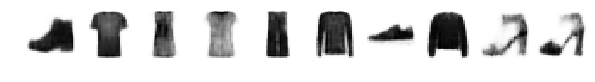

Cost after 100 batches: Tr 254.42787170410156, Tst 256.3752746582031


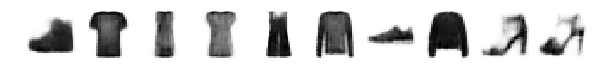

Cost after 150 batches: Tr 254.01837158203125, Tst 255.89024353027344


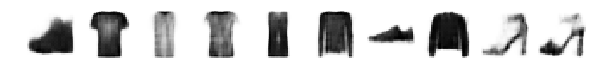

Cost after 200 batches: Tr 253.73773193359375, Tst 255.6302032470703


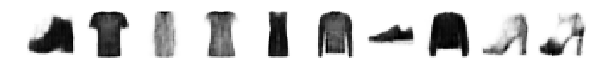

Cost after 250 batches: Tr 253.35299682617188, Tst 255.314453125


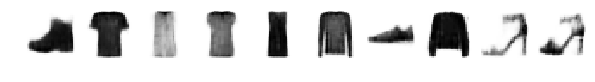

Cost after 300 batches: Tr 253.4378662109375, Tst 255.24517822265625


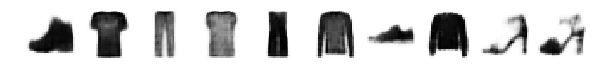

Cost after 350 batches: Tr 253.3889617919922, Tst 255.21817016601562


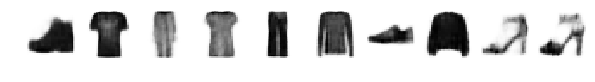

Cost after 400 batches: Tr 253.2442626953125, Tst 255.01304626464844


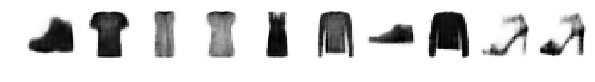

Cost after 450 batches: Tr 254.32286071777344, Tst 256.1190490722656


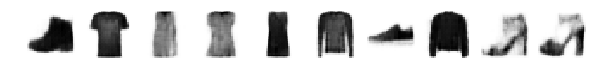

Cost after 500 batches: Tr 253.671630859375, Tst 255.49278259277344


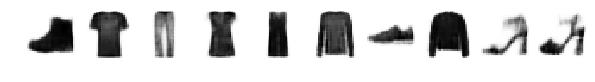

Cost after 550 batches: Tr 253.4884490966797, Tst 255.33692932128906


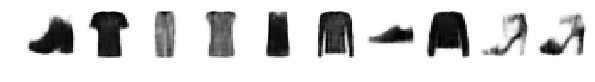

Cost after 0 batches: Tr 253.3083953857422, Tst 255.2281494140625


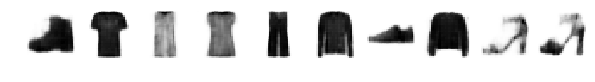

Cost after 50 batches: Tr 253.90133666992188, Tst 255.76499938964844


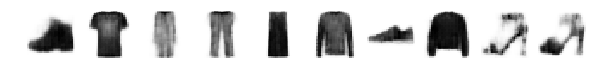

Cost after 100 batches: Tr 253.59686279296875, Tst 255.42897033691406


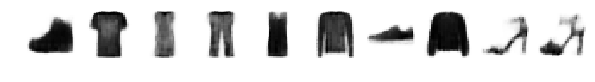

Cost after 150 batches: Tr 253.55116271972656, Tst 255.3843231201172


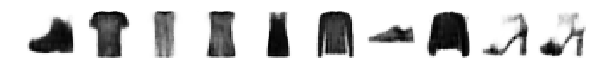

Cost after 200 batches: Tr 253.8169708251953, Tst 255.750732421875


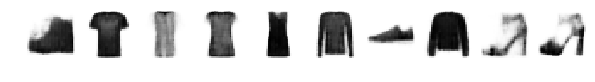

Cost after 250 batches: Tr 253.2393798828125, Tst 255.04620361328125


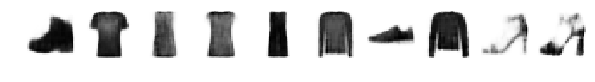

Cost after 300 batches: Tr 254.12283325195312, Tst 255.89598083496094


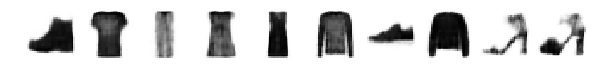

Cost after 350 batches: Tr 253.65133666992188, Tst 255.4674072265625


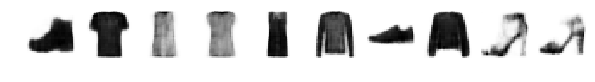

Cost after 400 batches: Tr 253.3191375732422, Tst 255.09864807128906


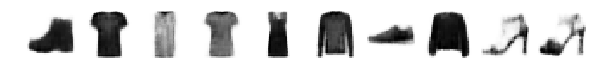

Cost after 450 batches: Tr 253.38906860351562, Tst 255.23822021484375


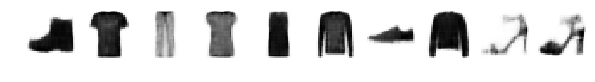

Cost after 500 batches: Tr 253.46994018554688, Tst 255.3350067138672


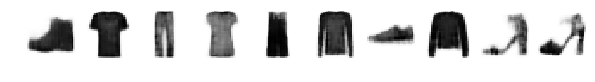

Cost after 550 batches: Tr 253.04251098632812, Tst 254.76609802246094


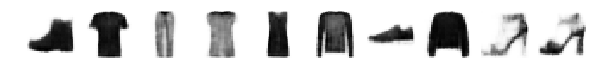

Cost after 0 batches: Tr 253.1290740966797, Tst 255.0638427734375


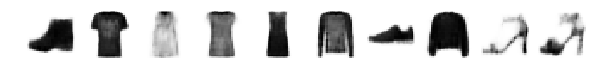

Cost after 50 batches: Tr 253.16323852539062, Tst 254.9824676513672


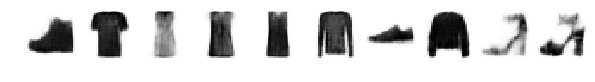

Cost after 100 batches: Tr 253.70004272460938, Tst 255.42935180664062


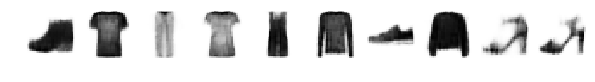

Cost after 150 batches: Tr 254.189453125, Tst 255.8751983642578


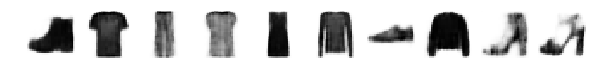

Cost after 200 batches: Tr 252.64915466308594, Tst 254.46292114257812


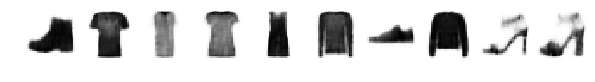

Cost after 250 batches: Tr 253.11199951171875, Tst 254.959228515625


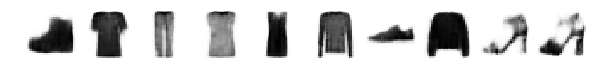

Cost after 300 batches: Tr 253.43336486816406, Tst 255.27032470703125


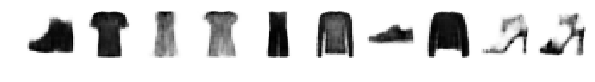

Cost after 350 batches: Tr 252.9497528076172, Tst 254.8125457763672


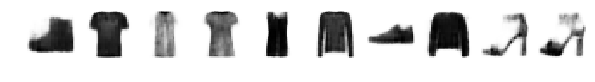

Cost after 400 batches: Tr 254.78286743164062, Tst 256.6213684082031


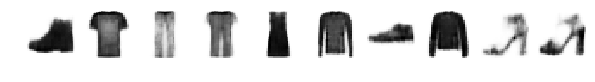

Cost after 450 batches: Tr 252.84938049316406, Tst 254.6429443359375


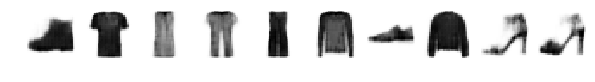

Cost after 500 batches: Tr 252.8848876953125, Tst 254.69940185546875


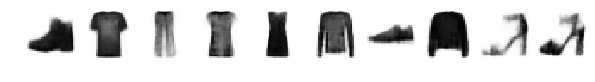

Cost after 550 batches: Tr 253.21380615234375, Tst 255.0009765625


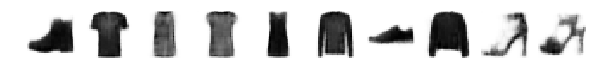

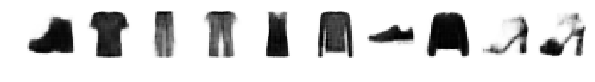

In [65]:
g_costs = model.train_full(g_tr_data, g_tr_data, g_tst_data, g_tst_data, num_epochs=10, 
                   info=True, infoplots=True)
g_costs.to_csv('costs.csv', float_format='%.2f')

# Train model and evaluate

In [ ]:
z = model.evaluate_AE_outputs(g_tr_data, g_tr_data)[0]
z_1 = z[g_tr_labels == 1]
z_2 = z[g_tr_labels == 2]

In [ ]:
feedfwd_z_1 = model.evaluate_z_outputs(z_1)
feedfwd_z_2 = model.evaluate_z_outputs(z_2)
print(feedfwd_z_1.shape)
print(feedfwd_z_2.shape)

In [ ]:
z_1_avg = np.mean(z_1, axis=0)
z_2_avg = np.mean(z_2, axis=0)
print(z_1_avg.shape)
print(z_2_avg.shape)

In [ ]:
def interpolate_z(z_1, z_2):
    """Linearly interpolate z coordinates of z_1 and z_2"""
    interpolation = np.zeros(shape=(10, len(z_1)))    
    for k in range(10):
        interpolation[k] = z_1 + (k/9)*(z_2 - z_1)
    return interpolation

In [ ]:
z_12 = interpolate_z(z_1_avg, z_2_avg)

In [ ]:
feedfwd_z_12 = model.evaluate_z_outputs(z_12)
print(feedfwd_z_12.shape)

In [ ]:
inspect_number(feedfwd_z_12, np.arange(10), savefig=False)